<a href="https://colab.research.google.com/github/shravan1994/disaster_prediction_using_tweets/blob/main/DisasterTweets_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
if __name__ == '__main__':
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if __name__ == '__main__':
  import os
  os.environ['KAGGLE_CONFIG_DIR'] = "."

  !kaggle competitions download -c nlp-getting-started
  !unzip nlp-getting-started.zip -d 'data'

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 87.3MB/s]
Archive:  nlp-getting-started.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
import seaborn as sns

In [ ]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
print(train_df.shape)
test_data = pd.read_csv('data/test.csv')
print(test_data.shape)

(7613, 5)
(3263, 4)


In [ ]:
train_df[~train_df['location'].isna()].head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


## Lets see how many records from both classes.

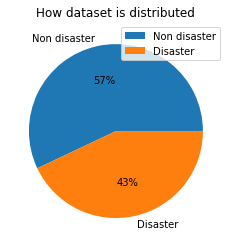

In [ ]:
target_count = train_df.groupby('target').agg({'id': 'count'}).reset_index()
target_count['target'] = target_count['target'].replace(0, 'Non disaster').replace(1, 'Disaster')
target_count.head()

plt.pie(target_count['id'], labels=target_count['target'], autopct='%1.0f%%')
plt.legend()
plt.title('How dataset is distributed')
plt.show()

<h3>43% of tweets are related to disaster and rest of normal tweets</h3>

## How many tweets has a keyword?

In [ ]:
not_having_keyword = train_df[train_df['keyword'] == 'nan']
print('Tweets not having field keyword: ', len(not_having_keyword))

Tweets not having field keyword:  0


In [ ]:
# train_df['keyword'].tolist()
not_having_keyword = train_df[train_df['keyword'] == 'nan']
not_having_keyword.shape

(61, 5)

## How the keyword column is affecting the target label

In [ ]:
train_df['keyword'] = train_df['keyword'].astype(str).apply(lambda x: urllib.parse.unquote(x))
keyword_df =  train_df.groupby(['keyword', 'target']).agg({'id': 'count'}).reset_index().rename(columns={'id': 'total'})
keyword_df = keyword_df.sort_values('keyword', ascending=False)
keyword_df.head()

,keyword,target,total
439,wrecked,1,3
438,wrecked,0,36
437,wreckage,1,39
436,wreck,1,7
435,wreck,0,30


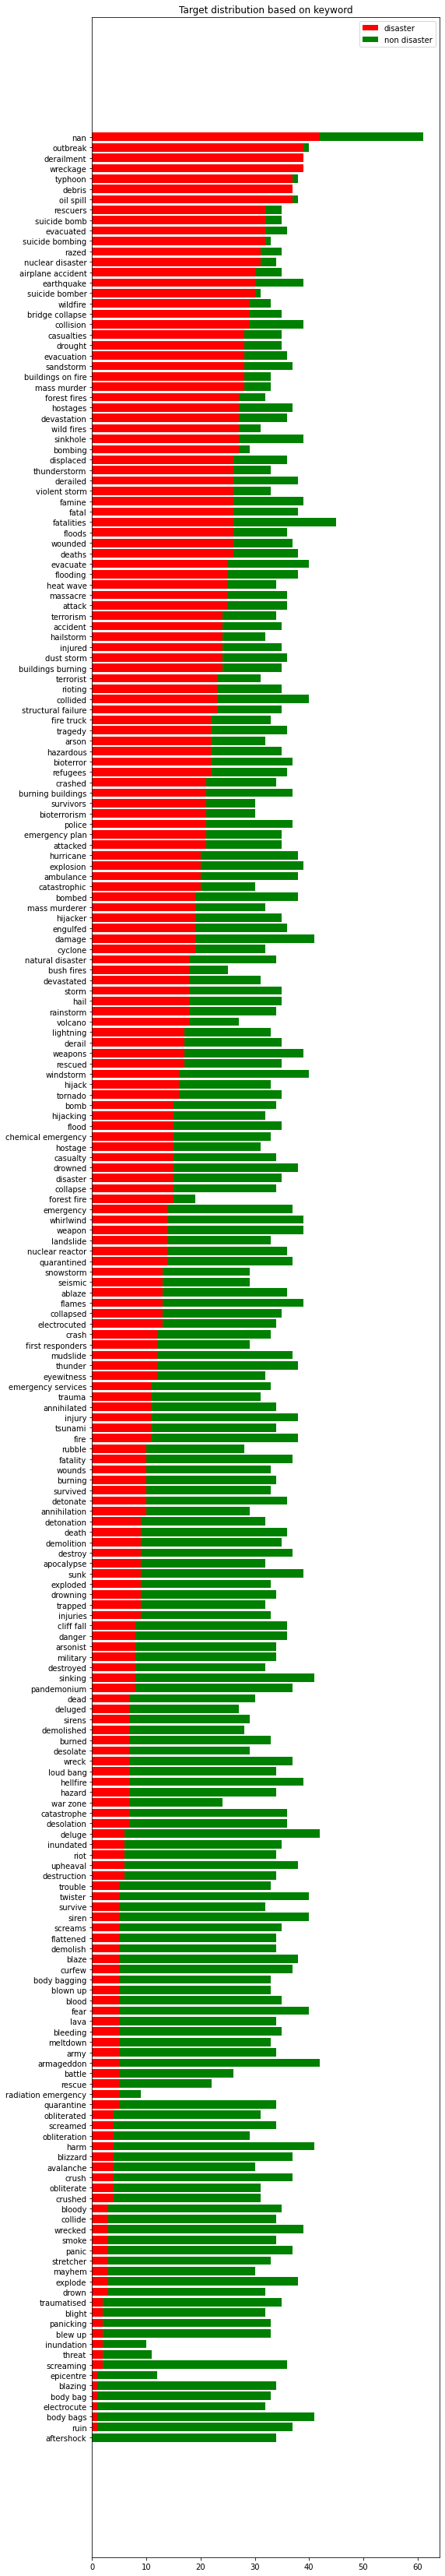

In [ ]:
keyword_to_target_count = {}
for row in keyword_df.itertuples():
  target0 = row.total if not row.target else 0
  target1 = row.total if row.target else 0

  if not keyword_to_target_count.get(row.keyword):
    keyword_to_target_count.update({
        row.keyword: {
            'keyword': row.keyword,
            'target_0': 0,
            'target_1': 0
        }
    })
  
  keyword_to_target_count.get(row.keyword)['target_0'] += target0 
  keyword_to_target_count.get(row.keyword)['target_1'] += target1


keyword_df_agg = pd.DataFrame(list(keyword_to_target_count.values()))
keyword_df_agg = keyword_df_agg.sort_values('target_1')

fig = plt.figure(figsize=(8, 60))
b1 = plt.barh(keyword_df_agg['keyword'], keyword_df_agg['target_1'], color='red', label='disaster')
b2 = plt.barh(keyword_df_agg['keyword'], keyword_df_agg['target_0'], left=keyword_df_agg['target_1'], color='green', label='non disaster')
plt.legend()
plt.title('Target distribution based on keyword')
plt.show()

<h3><b>Observations:</b> tweets having words like outbreak, derailment, wreckage, typhoon and debris mostly are related to real disasters.</h3>

<h3>Words like aftershock, ruin body bags, electrocute and so on are related to normal tweets mostly.</h3>

## how many tweets are missing locations?

In [ ]:
not_having_location = train_df[train_df['location'].isna()]
print('Tweets not having field location: ', len(not_having_location))

Tweets not having field location:  2533


## are there any locations from where we getting more disater related tweets?

In [ ]:
!pip install geopy
!pip install https://github.com/elyase/geotext/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 2.3 MB 284 kB/s
  Created wheel for geotext: filename=geotext-0.3.0-py2.py3-none-any.whl size=2272483 sha256=8aaf40941e1f71852969fa23af1db9aecf425191bb732630c3277f92b2639c1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-m8fky5f5/wheels/c3/82/e9/208ca98c5e7fd6edcd87669e8270db1d858cd078d230452cd5
Successfully built geotext


In [ ]:
from geotext import GeoText

country_df = train_df[['id', 'location', 'target']].copy()
country_df['location'] = country_df['location'].fillna('')
country_df['city'] = country_df['location'].apply(lambda x: GeoText(x).cities[0] if GeoText(x).cities else '')
country_df = country_df.groupby(['city', 'target']).agg({'id': 'count'}).reset_index()
country_df = country_df.sort_values('id', ascending=False)

# excluding the empty city names
country_df = country_df[country_df['city'] != '']
country_df.head()

,city,target,id
581,New York,0,86
463,London,0,62
865,Washington,1,38
464,London,1,37
582,New York,1,36


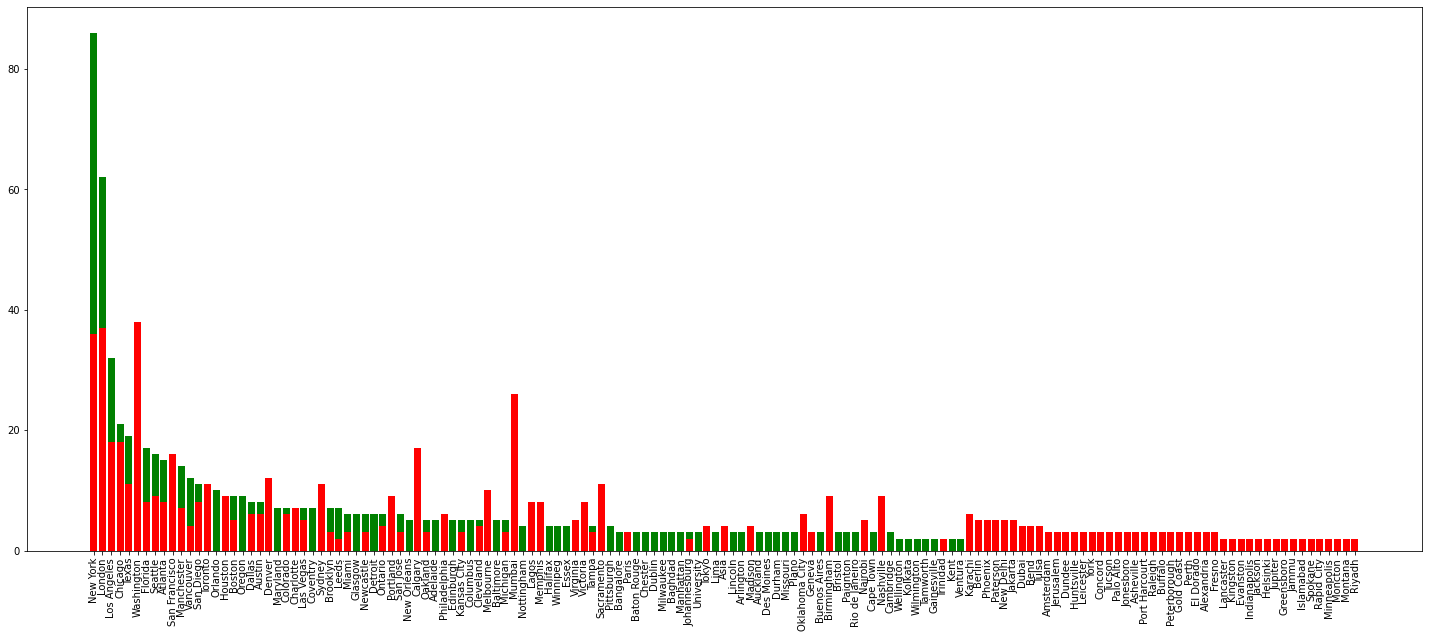

In [ ]:
country_df_0 = country_df[country_df['target'] == 0]
country_df_1 = country_df[country_df['target'] == 1]

plt.figure(figsize=(25, 10))
plt.bar(country_df_0[0:100]['city'], country_df_0[0:100]['id'], color='green')
plt.bar(country_df_1[0:100]['city'], country_df_1[0:100]['id'], color='red')
plt.xticks(rotation=90)
plt.show()

<h3><b>Observations:</b> From few cities we can see we only got the disaster related tweets and from few cities we only got normal tweets.
</h3>
<h3>
This can be a usefull feature, but the model trained using these features may not be very generalizable when used to predict disaster with real time data from tweeter.
</h3>
<h3>
because data we got is very less, using city name as features can improve our score on kaggle, but model won't be a generalized model.</h3>

## Check the tweet length
<p>It may be possible that tweets posted by people in disaster events may not have time to write long tweets, they may be shorter in length</p>

**Distribution of all tweet lengths**

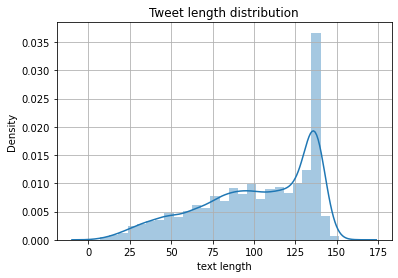

In [ ]:
tweet_length = train_df['text'].apply(lambda x: len(x))
sns.distplot(tweet_length)
plt.title('Tweet length distribution')
plt.xlabel('text length')
plt.grid()
plt.show()

<h3>most of the tweets are having length between 130 and 140.</h3>

**distribution of tweet length for disaster and non disastrous tweets**

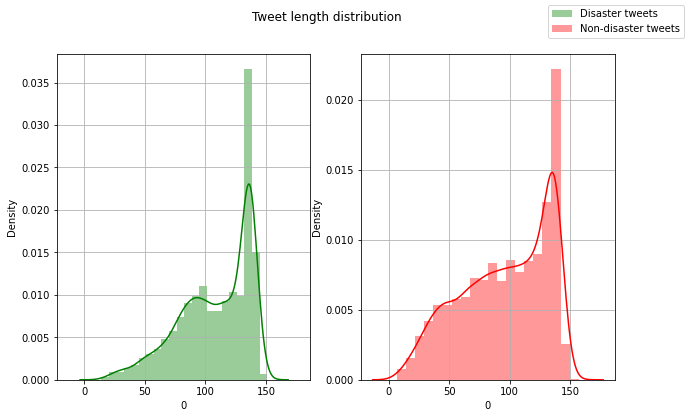

In [ ]:
tweet_length_df = train_df[['text', 'target']].apply(lambda x: pd.Series([len(x.text), x.target]), axis=1)
tweet_length_df_1 = tweet_length_df[tweet_length_df[1] == 1]
tweet_length_df_0 = tweet_length_df[tweet_length_df[1] == 0]

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 6))
sns.distplot(tweet_length_df_1[0], ax=ax1, color='green', label='Disaster tweets')
sns.distplot(tweet_length_df_0[0], ax=ax2, color='red', label='Non-disaster tweets')
f.suptitle('Tweet length distribution')
f.legend()
ax1.grid()
ax2.grid()
plt.show()

## Word count per tweet

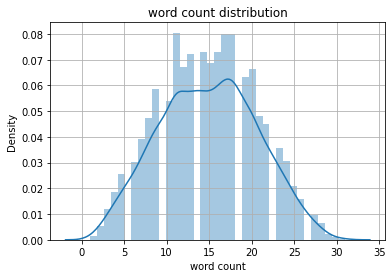

In [ ]:
tweet_length = train_df['text'].apply(lambda x: len(x.split()))
sns.distplot(tweet_length)
plt.title('word count distribution')
plt.xlabel('word count')
plt.grid()
plt.show()

## Check if there are any duplicate values in training data

In [ ]:
duplicated_df = train_df.groupby('text').agg(
    target_list=('target', list),
    target_count=('target', len)
).reset_index()

duplicated_df = duplicated_df[duplicated_df['target_count'] > 1]
duplicated_df.head()

,text,target_list,target_count
24,#Allah describes piling up #wealth thinking it...,"[0, 0, 1]",3
45,#Bestnaijamade: 16yr old PKK suicide bomber wh...,"[1, 1, 1, 1, 1, 1]",6
115,#KCA #VoteJKT48ID 12News: UPDATE: A family of ...,"[1, 1]",2
141,#Myanmar Displaced #Rohingya at #Sittwe point...,"[1, 1]",2
157,#Newswatch: 2 vehicles collided at Lock and La...,"[1, 1]",2


<h3>We can see that some tweets are appearing twice in training data and they have different target labels</h3>

<h3> we need to mark check such tweets and label them manually.</h3>

## Lets take a look at tweet data, by randomly picking any 10 records.

In [ ]:
train_df.sample(10)['text'].tolist()

['Alton brown just did a livestream and he burned the butter and touched the hot plate too soon and made a nut joke http://t.co/gvd7fcx8iZ',
 "Tomorrow's Announcement VODs http://t.co/cUbze5MIZm",
 '@Demolition_d best grill u fkn pleb',
 "@abandonedpics You should delete this one it's not an abbandoned nor sinking. That\x89Ûªs the darsena of the Castello scaligero di Sirmione.",
 'Learning from the Legacy of a Catastrophic Eruption http://t.co/RbmuCURS2F',
 'The media needs to stop publicizing mass murder. So many sick people want the eyes of the world and the media... http://t.co/QZlPFHpwDO',
 "12' 72W CREE LED Work Light Bar Alloy Spot Flood Combo Diving Offroad 4WD Boat - Full read\x89Û_ http://t.co/XWN7rgVkzC http://t.co/SWPDQ84boI",
 "'Climate change could be catastrophic -- but it does have some benefits.' Really @weathernetwork?!?! http://t.co/IBx3cragtt",
 "Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...",
 '#golf McIlroy fue

In [ ]:
train_df.sample(10)['text'].tolist()

['#Islamic #state issue a new holiday #brochure lovely swimming pool for drowning in shooting range and the downside it costs a #bomb',
 "53 years ago this week is the anniversary of Marilyn Monroe's death RIPRIPRIP",
 'My brother is crying cause the thunder lmao',
 "IMAGINE A DOCTOR TREATING AN #EBOLA PATIENT WITHOUT EVER PLACING HIMSELF IN HARM'S WAY. http://t.co/dliZfkk30Y",
 'remember that time goku gave life to a dead birb \nwhat the hell goku',
 'C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980:    submitt... http://t.co/nbugSMqLRG #aviationaddicts',
 'Author Interview Michele Rosenthal-author of Your Life After Trauma.',
 'The feeling of lonelyness has sunk into me strange depressing feeling.',
 '#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/wvTPuRYx63 #prebreak #best',
 'Blizzard of Auz @ 9 pm CST @RadioRiffRocks / http://t.co/pjLDA9HD5v    2 hrs of Rock to make your hump day complete! http://t.co/3

### **Observations**
<p>
as we can see here, we have lot of bad text, 

We will need to,
* remove special charectors like : @, #, [, ], ' and so on.  
* I guess we can use the hashtags, we have to extract it out and see if we can predict target labels using those.
* Also lets check if urls in text data can be usefull here.
*  We should keep the punctuations like ., ?, !, and remove all others, because these indicate the tone of the conversation, but need to add space between the word and punctuation symbol, so that we can consider them as a seperate word. 
for example, <b>They turned Jasmines house into a war zone??</b> should be converted to <b>They turned Jasmines house into a war zone ??</b>
This way, the punctuation symbols will be considered as new word.
* I see there are some punctuation symbols, repeating like fullstop is given three times, so lets remove multiple such occurences also.

*   need to do decontractions
*   any numerical values between square bracket need to be removed.
*   any words starting with \x, should be removed.
</p>







## Lets extract hashtags from text data and see if they are useful.

In [ ]:
import re
def extract_hash_tags(text):
  return re.findall(r"#(\w+)", text)

hash_tags_df = train_df.copy()
hash_tags_df['hashtags'] = hash_tags_df['text'].apply(lambda x: extract_hash_tags(x))
hash_tags_df.head()

,id,keyword,location,text,target,hashtags
0,1,nan,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,4,nan,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,5,nan,NaN,All residents asked to 'shelter in place' are ...,1,[]
3,6,nan,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,7,nan,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[Alaska, wildfires]"


In [ ]:
hash_tags_df_1 = hash_tags_df[hash_tags_df['target'] == 1]
hash_tags_df_0 = hash_tags_df[hash_tags_df['target'] == 0]

disaster_hashtags = []
for row in hash_tags_df_1['hashtags'].tolist():
  disaster_hashtags.extend(row)

non_disaster_hashtags = []
for row in hash_tags_df_0['hashtags'].tolist():
  non_disaster_hashtags.extend(row)

**<h4>Printing a wordcloud for both disaster related hashtags and non disaster related hashtags</h4>**

**Disaster related hashtags**

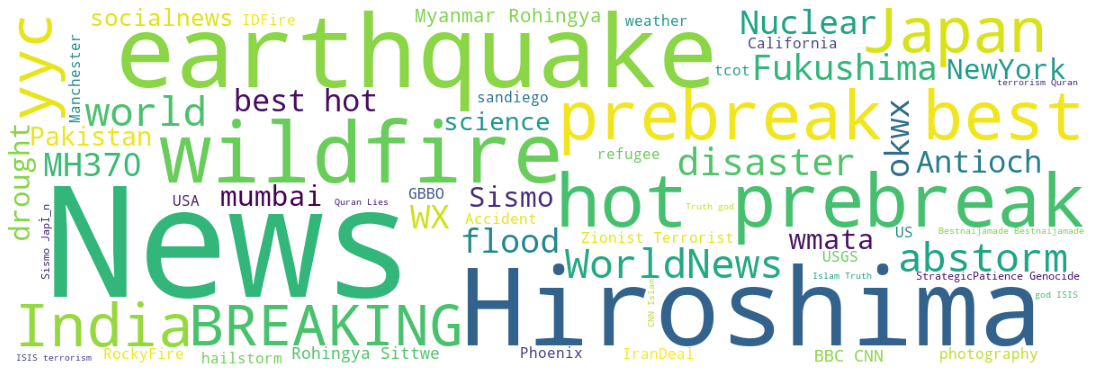

In [ ]:
from wordcloud import WordCloud

disaster_words = ' '.join(disaster_hashtags)
wordcloud = WordCloud(width=1200, height=400, background_color ='white', min_font_size=10).generate(disaster_words)
                      
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**Non disaster related hashtags**

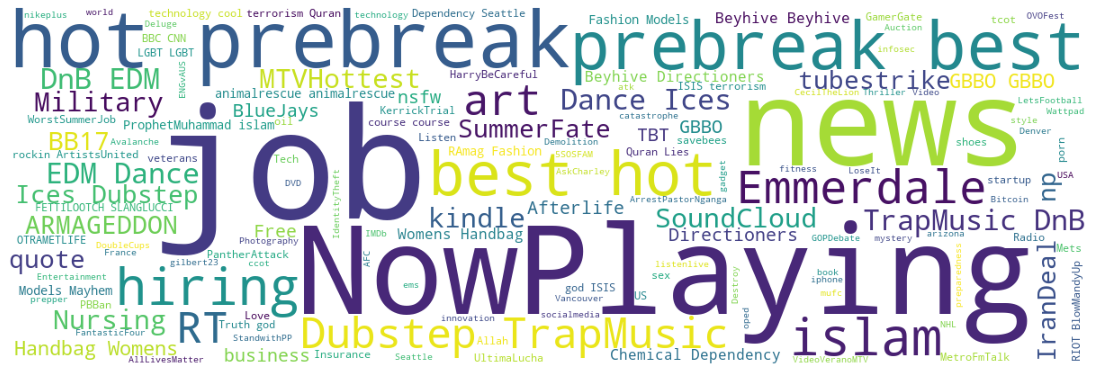

In [ ]:
from wordcloud import WordCloud

disaster_words = ' '.join(non_disaster_hashtags)
wordcloud = WordCloud(width=1200, height=400, background_color ='white', min_font_size=10).generate(disaster_words)
                      
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

<h3><b>Observations: </b> we can see there is clear distinction between the kind of hashtags are used with disaster related tweets and non disaster related tweets. hashtags will be usefull.</h3>

## Extract links from tweets and see if we can find any pattern there.

In [ ]:
import re
def extract_urls(text):
  return re.findall('(https?:\/\/[^ ]*)', text)
  

urls_df = train_df.copy()
urls_df['urls'] = urls_df['text'].apply(lambda x: extract_urls(x))
urls_df.head()

,id,keyword,location,text,target,urls
0,1,nan,NaN,Our Deeds are the Reason of this #earthquake M...,1,[]
1,4,nan,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,5,nan,NaN,All residents asked to 'shelter in place' are ...,1,[]
3,6,nan,NaN,"13,000 people receive #wildfires evacuation or...",1,[]
4,7,nan,NaN,Just got sent this photo from Ruby #Alaska as ...,1,[]


In [ ]:
urls_df_1 = urls_df[urls_df['target'] == 1]
urls_df_0 = urls_df[urls_df['target'] == 0]

disaster_urls = []
for row in urls_df_1['urls'].tolist():
  disaster_urls.extend(row)

non_disaster_urls = []
for row in urls_df_0['urls'].tolist():
  non_disaster_urls.extend(row)

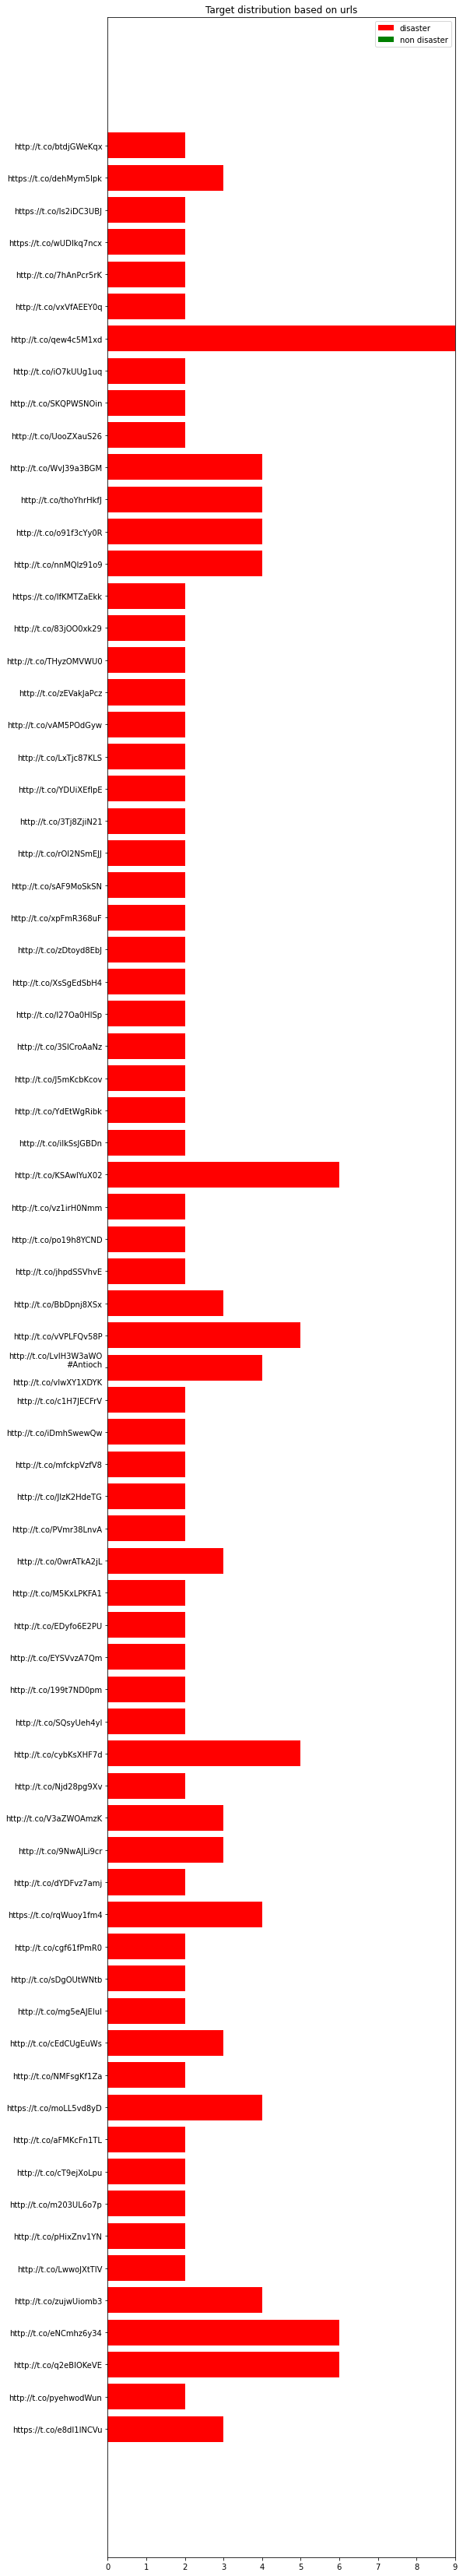

In [ ]:
url_counts = {}

for url in disaster_urls:
  if not url_counts.get(url):
    url_counts.update({
        url: {
            'url': url,
            'target_0': 0,
            'target_1': 0,
        }
    })
  url_counts[url]['target_1'] += 1

for url in non_disaster_urls:
  if not url_counts.get(url):
    url_counts.update({
        url: {
            'url': url,
            'target_0': 0,
            'target_1': 0,
        }
    })
  url_counts[url]['target_1'] += 1

url_df_agg = pd.DataFrame(list(url_counts.values()))
url_df_agg = url_df_agg[(url_df_agg['target_0'] > 1) | (url_df_agg['target_1'] > 1)]
url_df_agg.head()

fig = plt.figure(figsize=(8, 60))
b1 = plt.barh(url_df_agg['url'], url_df_agg['target_1'], color="red", label='disaster')
b2 = plt.barh(url_df_agg['url'], url_df_agg['target_0'], left=url_df_agg['target_1'], color='green', label='non disaster')
plt.legend()
plt.title('Target distribution based on urls')
plt.show()

<h3><b>Observation:</b> We can not get any patterns here using the urls.</h3>
<h3>We will remove urls from tweets as well while preprocessing.</h3>